In [1]:
#from google.colab import drive

import time
import zipfile
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
drive.mount('/content/drive')
!ls /content/drive



NameError: name 'drive' is not defined

In [ ]:
zip_file='/content/drive/MyDrive/archive.zip'

z=zipfile.ZipFile(zip_file,'r')
z.extractall()

print(os.listdir())

In [ ]:
!ls

In [2]:
images_path = Path('images')
anno_path = Path('annotations')


def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\road0.png,267,400,trafficlight,98,62,208,232
1,images\road1.png,400,283,trafficlight,154,63,258,281
2,images\road10.png,400,267,trafficlight,106,3,244,263
3,images\road100.png,400,385,speedlimit,35,5,363,326
4,images\road101.png,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
872,images\road95.png,300,400,stop,90,101,268,257
873,images\road96.png,400,267,stop,209,58,326,179
874,images\road97.png,400,267,stop,42,66,130,154
875,images\road98.png,400,267,stop,138,17,376,245


In [4]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [5]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\road0.png,267,400,3,98,62,208,232
1,images\road1.png,400,283,3,154,63,258,281
2,images\road10.png,400,267,3,106,3,244,263
3,images\road100.png,400,385,0,35,5,363,326
4,images\road101.png,400,200,0,195,7,392,194


In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [7]:
IM_SIZE = 300

In [8]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images\road0.png,267,400,3,98,62,208,232,images_resized\road0.png,"[46.0, 110.0, 173.0, 233.0]"
1,images\road1.png,400,283,3,154,63,258,281,images_resized\road1.png,"[66.0, 115.0, 297.0, 193.0]"
2,images\road10.png,400,267,3,106,3,244,263,images_resized\road10.png,"[3.0, 79.0, 295.0, 182.0]"
3,images\road100.png,400,385,0,35,5,363,326,images_resized\road100.png,"[4.0, 26.0, 253.0, 272.0]"
4,images\road101.png,400,200,0,195,7,392,194,images_resized\road101.png,"[10.0, 146.0, 291.0, 293.0]"


(293, 400, 3)


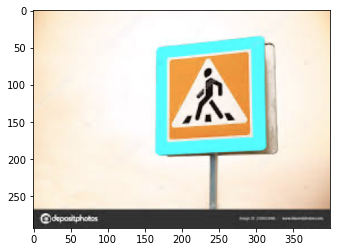

In [9]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)


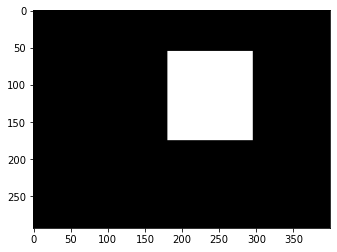

In [10]:
plt.imshow(Y, cmap='gray')

In [11]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized\road120.png


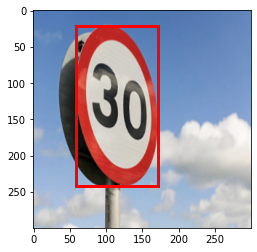

In [12]:
number = 25
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

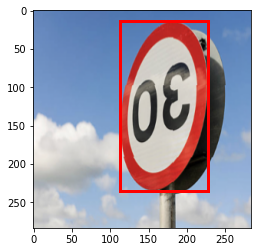

In [13]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

In [14]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [15]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [16]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [17]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Graf_35/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [25]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)
epochs = 2500
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [23]:
def train():
    for i in range(epochs):
      
        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total
        if i%10==0:
          torch.save(model.state_dict(),'model.pth')
        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [26]:
train()

Epoch [1/2500]. train_loss 550.240 val_loss 516.076 val_acc 0.608
Epoch [2/2500]. train_loss 531.820 val_loss 596.524 val_acc 0.142
Epoch [3/2500]. train_loss 508.273 val_loss 497.560 val_acc 0.608
Epoch [4/2500]. train_loss 458.407 val_loss 416.894 val_acc 0.716
Epoch [5/2500]. train_loss 386.767 val_loss 677.479 val_acc 0.250
Epoch [6/2500]. train_loss 310.989 val_loss 376.208 val_acc 0.625
Epoch [7/2500]. train_loss 232.207 val_loss 190.901 val_acc 0.682
Epoch [8/2500]. train_loss 175.643 val_loss 164.911 val_acc 0.614
Epoch [9/2500]. train_loss 153.217 val_loss 154.179 val_acc 0.574
Epoch [10/2500]. train_loss 144.010 val_loss 148.417 val_acc 0.665
Epoch [11/2500]. train_loss 142.819 val_loss 143.163 val_acc 0.682
Epoch [12/2500]. train_loss 142.171 val_loss 155.842 val_acc 0.705
Epoch [13/2500]. train_loss 137.172 val_loss 142.300 val_acc 0.688
Epoch [14/2500]. train_loss 134.681 val_loss 136.319 val_acc 0.688
Epoch [15/2500]. train_loss 129.542 val_loss 135.150 val_acc 0.705
Epoc

Epoch [127/2500]. train_loss 47.388 val_loss 53.155 val_acc 0.784
Epoch [128/2500]. train_loss 43.208 val_loss 54.929 val_acc 0.750
Epoch [129/2500]. train_loss 46.134 val_loss 56.487 val_acc 0.790
Epoch [130/2500]. train_loss 45.523 val_loss 49.592 val_acc 0.790
Epoch [131/2500]. train_loss 48.474 val_loss 57.639 val_acc 0.790
Epoch [132/2500]. train_loss 46.188 val_loss 54.139 val_acc 0.790
Epoch [133/2500]. train_loss 45.374 val_loss 51.182 val_acc 0.778
Epoch [134/2500]. train_loss 44.232 val_loss 48.694 val_acc 0.761
Epoch [135/2500]. train_loss 43.190 val_loss 55.007 val_acc 0.750
Epoch [136/2500]. train_loss 42.980 val_loss 49.581 val_acc 0.744
Epoch [137/2500]. train_loss 44.805 val_loss 57.132 val_acc 0.744
Epoch [138/2500]. train_loss 48.238 val_loss 55.966 val_acc 0.744
Epoch [139/2500]. train_loss 47.943 val_loss 57.071 val_acc 0.739
Epoch [140/2500]. train_loss 46.380 val_loss 51.448 val_acc 0.790
Epoch [141/2500]. train_loss 43.014 val_loss 52.551 val_acc 0.767
Epoch [142

Epoch [252/2500]. train_loss 42.769 val_loss 48.831 val_acc 0.835
Epoch [253/2500]. train_loss 42.524 val_loss 52.745 val_acc 0.801
Epoch [254/2500]. train_loss 42.883 val_loss 51.840 val_acc 0.830
Epoch [255/2500]. train_loss 42.882 val_loss 48.628 val_acc 0.830
Epoch [256/2500]. train_loss 39.388 val_loss 49.182 val_acc 0.795
Epoch [257/2500]. train_loss 43.211 val_loss 52.685 val_acc 0.795
Epoch [258/2500]. train_loss 44.034 val_loss 49.592 val_acc 0.835
Epoch [259/2500]. train_loss 41.868 val_loss 52.298 val_acc 0.812
Epoch [260/2500]. train_loss 46.014 val_loss 55.000 val_acc 0.835
Epoch [261/2500]. train_loss 45.800 val_loss 46.858 val_acc 0.824
Epoch [262/2500]. train_loss 41.112 val_loss 46.797 val_acc 0.835
Epoch [263/2500]. train_loss 46.081 val_loss 51.807 val_acc 0.830
Epoch [264/2500]. train_loss 38.983 val_loss 49.359 val_acc 0.830
Epoch [265/2500]. train_loss 40.317 val_loss 50.349 val_acc 0.830
Epoch [266/2500]. train_loss 46.629 val_loss 52.111 val_acc 0.818
Epoch [267

Epoch [377/2500]. train_loss 42.145 val_loss 48.907 val_acc 0.841
Epoch [378/2500]. train_loss 40.622 val_loss 48.173 val_acc 0.869
Epoch [379/2500]. train_loss 39.180 val_loss 49.019 val_acc 0.852
Epoch [380/2500]. train_loss 42.433 val_loss 48.371 val_acc 0.858
Epoch [381/2500]. train_loss 39.622 val_loss 51.592 val_acc 0.841
Epoch [382/2500]. train_loss 44.834 val_loss 52.784 val_acc 0.858
Epoch [383/2500]. train_loss 40.758 val_loss 46.818 val_acc 0.864
Epoch [384/2500]. train_loss 37.180 val_loss 51.707 val_acc 0.858
Epoch [385/2500]. train_loss 43.511 val_loss 47.389 val_acc 0.824
Epoch [386/2500]. train_loss 44.026 val_loss 51.313 val_acc 0.835
Epoch [387/2500]. train_loss 39.779 val_loss 49.763 val_acc 0.852
Epoch [388/2500]. train_loss 42.762 val_loss 47.144 val_acc 0.824
Epoch [389/2500]. train_loss 46.085 val_loss 52.249 val_acc 0.841
Epoch [390/2500]. train_loss 44.649 val_loss 62.817 val_acc 0.830
Epoch [391/2500]. train_loss 41.868 val_loss 45.250 val_acc 0.858
Epoch [392

Epoch [502/2500]. train_loss 38.568 val_loss 53.151 val_acc 0.869
Epoch [503/2500]. train_loss 40.653 val_loss 45.282 val_acc 0.881
Epoch [504/2500]. train_loss 38.483 val_loss 48.807 val_acc 0.852
Epoch [505/2500]. train_loss 39.281 val_loss 42.757 val_acc 0.869
Epoch [506/2500]. train_loss 40.320 val_loss 47.938 val_acc 0.858
Epoch [507/2500]. train_loss 41.149 val_loss 59.130 val_acc 0.847
Epoch [508/2500]. train_loss 42.261 val_loss 51.892 val_acc 0.875
Epoch [509/2500]. train_loss 41.848 val_loss 48.174 val_acc 0.864
Epoch [510/2500]. train_loss 39.566 val_loss 53.630 val_acc 0.869
Epoch [511/2500]. train_loss 38.033 val_loss 47.848 val_acc 0.858
Epoch [512/2500]. train_loss 42.313 val_loss 47.886 val_acc 0.869
Epoch [513/2500]. train_loss 40.891 val_loss 49.715 val_acc 0.869
Epoch [514/2500]. train_loss 37.714 val_loss 44.119 val_acc 0.841
Epoch [515/2500]. train_loss 38.146 val_loss 52.353 val_acc 0.852
Epoch [516/2500]. train_loss 36.231 val_loss 49.831 val_acc 0.875
Epoch [517

Epoch [627/2500]. train_loss 36.992 val_loss 46.465 val_acc 0.864
Epoch [628/2500]. train_loss 42.442 val_loss 50.426 val_acc 0.875
Epoch [629/2500]. train_loss 39.727 val_loss 46.193 val_acc 0.881
Epoch [630/2500]. train_loss 41.356 val_loss 52.530 val_acc 0.875
Epoch [631/2500]. train_loss 39.368 val_loss 47.937 val_acc 0.858
Epoch [632/2500]. train_loss 35.005 val_loss 44.739 val_acc 0.864
Epoch [633/2500]. train_loss 40.149 val_loss 51.441 val_acc 0.869
Epoch [634/2500]. train_loss 36.361 val_loss 44.260 val_acc 0.869
Epoch [635/2500]. train_loss 39.232 val_loss 45.458 val_acc 0.869
Epoch [636/2500]. train_loss 42.456 val_loss 52.645 val_acc 0.881
Epoch [637/2500]. train_loss 39.862 val_loss 47.923 val_acc 0.886
Epoch [638/2500]. train_loss 42.042 val_loss 49.908 val_acc 0.875
Epoch [639/2500]. train_loss 39.372 val_loss 48.732 val_acc 0.875
Epoch [640/2500]. train_loss 39.181 val_loss 53.858 val_acc 0.892
Epoch [641/2500]. train_loss 36.804 val_loss 45.974 val_acc 0.864
Epoch [642

Epoch [752/2500]. train_loss 37.721 val_loss 55.009 val_acc 0.875
Epoch [753/2500]. train_loss 35.279 val_loss 52.879 val_acc 0.864
Epoch [754/2500]. train_loss 37.356 val_loss 47.391 val_acc 0.869
Epoch [755/2500]. train_loss 37.594 val_loss 44.626 val_acc 0.903
Epoch [756/2500]. train_loss 36.139 val_loss 49.461 val_acc 0.886
Epoch [757/2500]. train_loss 40.714 val_loss 45.930 val_acc 0.881
Epoch [758/2500]. train_loss 38.170 val_loss 54.803 val_acc 0.886
Epoch [759/2500]. train_loss 36.730 val_loss 48.792 val_acc 0.886
Epoch [760/2500]. train_loss 37.377 val_loss 55.305 val_acc 0.875
Epoch [761/2500]. train_loss 40.452 val_loss 44.680 val_acc 0.869
Epoch [762/2500]. train_loss 38.897 val_loss 47.713 val_acc 0.875
Epoch [763/2500]. train_loss 38.585 val_loss 47.519 val_acc 0.869
Epoch [764/2500]. train_loss 37.561 val_loss 52.705 val_acc 0.881
Epoch [765/2500]. train_loss 40.163 val_loss 48.397 val_acc 0.886
Epoch [766/2500]. train_loss 40.495 val_loss 51.327 val_acc 0.881
Epoch [767

Epoch [877/2500]. train_loss 36.573 val_loss 51.688 val_acc 0.881
Epoch [878/2500]. train_loss 39.591 val_loss 46.851 val_acc 0.886
Epoch [879/2500]. train_loss 39.270 val_loss 47.293 val_acc 0.881
Epoch [880/2500]. train_loss 40.753 val_loss 45.627 val_acc 0.864
Epoch [881/2500]. train_loss 38.755 val_loss 47.399 val_acc 0.864
Epoch [882/2500]. train_loss 42.233 val_loss 52.106 val_acc 0.881
Epoch [883/2500]. train_loss 39.183 val_loss 46.630 val_acc 0.892
Epoch [884/2500]. train_loss 39.522 val_loss 46.793 val_acc 0.898
Epoch [885/2500]. train_loss 38.918 val_loss 47.900 val_acc 0.875
Epoch [886/2500]. train_loss 36.920 val_loss 53.988 val_acc 0.864
Epoch [887/2500]. train_loss 39.678 val_loss 47.974 val_acc 0.864
Epoch [888/2500]. train_loss 40.029 val_loss 42.017 val_acc 0.892
Epoch [889/2500]. train_loss 37.086 val_loss 51.258 val_acc 0.886
Epoch [890/2500]. train_loss 42.221 val_loss 52.983 val_acc 0.881
Epoch [891/2500]. train_loss 41.609 val_loss 48.110 val_acc 0.886
Epoch [892

Epoch [1002/2500]. train_loss 36.808 val_loss 45.852 val_acc 0.875
Epoch [1003/2500]. train_loss 37.643 val_loss 45.514 val_acc 0.881
Epoch [1004/2500]. train_loss 34.881 val_loss 48.452 val_acc 0.864
Epoch [1005/2500]. train_loss 39.380 val_loss 48.234 val_acc 0.869
Epoch [1006/2500]. train_loss 37.860 val_loss 45.030 val_acc 0.892
Epoch [1007/2500]. train_loss 37.461 val_loss 45.467 val_acc 0.864
Epoch [1008/2500]. train_loss 39.018 val_loss 62.083 val_acc 0.858
Epoch [1009/2500]. train_loss 38.453 val_loss 52.173 val_acc 0.875
Epoch [1010/2500]. train_loss 35.830 val_loss 47.536 val_acc 0.864
Epoch [1011/2500]. train_loss 36.145 val_loss 46.564 val_acc 0.864
Epoch [1012/2500]. train_loss 35.866 val_loss 52.918 val_acc 0.852
Epoch [1013/2500]. train_loss 34.640 val_loss 46.626 val_acc 0.858
Epoch [1014/2500]. train_loss 38.363 val_loss 48.770 val_acc 0.864
Epoch [1015/2500]. train_loss 42.422 val_loss 47.136 val_acc 0.858
Epoch [1016/2500]. train_loss 38.928 val_loss 51.843 val_acc 0

Epoch [1125/2500]. train_loss 38.214 val_loss 46.540 val_acc 0.875
Epoch [1126/2500]. train_loss 37.536 val_loss 47.010 val_acc 0.858
Epoch [1127/2500]. train_loss 39.444 val_loss 49.300 val_acc 0.869
Epoch [1128/2500]. train_loss 34.648 val_loss 49.954 val_acc 0.864
Epoch [1129/2500]. train_loss 33.003 val_loss 48.588 val_acc 0.864
Epoch [1130/2500]. train_loss 39.030 val_loss 48.247 val_acc 0.875
Epoch [1131/2500]. train_loss 37.419 val_loss 46.536 val_acc 0.875
Epoch [1132/2500]. train_loss 40.683 val_loss 45.356 val_acc 0.864
Epoch [1133/2500]. train_loss 37.814 val_loss 46.238 val_acc 0.875
Epoch [1134/2500]. train_loss 39.144 val_loss 50.436 val_acc 0.869
Epoch [1135/2500]. train_loss 39.933 val_loss 47.384 val_acc 0.875
Epoch [1136/2500]. train_loss 37.286 val_loss 45.496 val_acc 0.869
Epoch [1137/2500]. train_loss 38.724 val_loss 46.375 val_acc 0.869
Epoch [1138/2500]. train_loss 37.430 val_loss 52.157 val_acc 0.886
Epoch [1139/2500]. train_loss 36.073 val_loss 52.362 val_acc 0

Epoch [1248/2500]. train_loss 36.755 val_loss 50.280 val_acc 0.875
Epoch [1249/2500]. train_loss 40.916 val_loss 50.623 val_acc 0.869
Epoch [1250/2500]. train_loss 38.139 val_loss 46.057 val_acc 0.875
Epoch [1251/2500]. train_loss 40.773 val_loss 50.507 val_acc 0.852
Epoch [1252/2500]. train_loss 37.002 val_loss 51.284 val_acc 0.864
Epoch [1253/2500]. train_loss 39.192 val_loss 49.036 val_acc 0.881
Epoch [1254/2500]. train_loss 36.639 val_loss 49.617 val_acc 0.881
Epoch [1255/2500]. train_loss 34.911 val_loss 48.893 val_acc 0.864
Epoch [1256/2500]. train_loss 36.609 val_loss 46.900 val_acc 0.858
Epoch [1257/2500]. train_loss 40.825 val_loss 47.947 val_acc 0.869
Epoch [1258/2500]. train_loss 36.053 val_loss 49.740 val_acc 0.875
Epoch [1259/2500]. train_loss 37.907 val_loss 49.638 val_acc 0.875
Epoch [1260/2500]. train_loss 33.136 val_loss 49.915 val_acc 0.875
Epoch [1261/2500]. train_loss 37.101 val_loss 50.805 val_acc 0.881
Epoch [1262/2500]. train_loss 43.513 val_loss 47.902 val_acc 0

Epoch [1371/2500]. train_loss 32.092 val_loss 50.244 val_acc 0.864
Epoch [1372/2500]. train_loss 38.165 val_loss 46.815 val_acc 0.869
Epoch [1373/2500]. train_loss 39.755 val_loss 49.850 val_acc 0.864
Epoch [1374/2500]. train_loss 38.806 val_loss 46.309 val_acc 0.864
Epoch [1375/2500]. train_loss 38.838 val_loss 48.474 val_acc 0.864
Epoch [1376/2500]. train_loss 40.829 val_loss 48.570 val_acc 0.864
Epoch [1377/2500]. train_loss 37.683 val_loss 55.735 val_acc 0.864
Epoch [1378/2500]. train_loss 38.798 val_loss 48.156 val_acc 0.864
Epoch [1379/2500]. train_loss 38.185 val_loss 51.576 val_acc 0.852
Epoch [1380/2500]. train_loss 40.026 val_loss 52.114 val_acc 0.864
Epoch [1381/2500]. train_loss 42.143 val_loss 49.120 val_acc 0.875
Epoch [1382/2500]. train_loss 36.610 val_loss 44.378 val_acc 0.864
Epoch [1383/2500]. train_loss 40.054 val_loss 48.084 val_acc 0.875
Epoch [1384/2500]. train_loss 40.556 val_loss 46.445 val_acc 0.869
Epoch [1385/2500]. train_loss 36.307 val_loss 43.680 val_acc 0

Epoch [1494/2500]. train_loss 42.181 val_loss 46.878 val_acc 0.858
Epoch [1495/2500]. train_loss 35.047 val_loss 47.498 val_acc 0.875
Epoch [1496/2500]. train_loss 40.199 val_loss 45.577 val_acc 0.881
Epoch [1497/2500]. train_loss 39.642 val_loss 43.766 val_acc 0.892
Epoch [1498/2500]. train_loss 32.182 val_loss 44.070 val_acc 0.892
Epoch [1499/2500]. train_loss 36.630 val_loss 45.226 val_acc 0.892
Epoch [1500/2500]. train_loss 38.856 val_loss 46.592 val_acc 0.881
Epoch [1501/2500]. train_loss 40.322 val_loss 46.404 val_acc 0.881
Epoch [1502/2500]. train_loss 36.267 val_loss 49.223 val_acc 0.875
Epoch [1503/2500]. train_loss 36.797 val_loss 49.104 val_acc 0.875
Epoch [1504/2500]. train_loss 42.215 val_loss 53.278 val_acc 0.886
Epoch [1505/2500]. train_loss 39.386 val_loss 47.422 val_acc 0.875
Epoch [1506/2500]. train_loss 36.711 val_loss 49.993 val_acc 0.875
Epoch [1507/2500]. train_loss 38.497 val_loss 50.924 val_acc 0.875
Epoch [1508/2500]. train_loss 41.964 val_loss 51.936 val_acc 0

Epoch [1617/2500]. train_loss 40.312 val_loss 49.717 val_acc 0.858
Epoch [1618/2500]. train_loss 36.407 val_loss 48.863 val_acc 0.869
Epoch [1619/2500]. train_loss 39.450 val_loss 47.273 val_acc 0.881
Epoch [1620/2500]. train_loss 38.918 val_loss 48.587 val_acc 0.869
Epoch [1621/2500]. train_loss 38.252 val_loss 50.365 val_acc 0.886
Epoch [1622/2500]. train_loss 38.150 val_loss 51.530 val_acc 0.869
Epoch [1623/2500]. train_loss 40.217 val_loss 49.695 val_acc 0.881
Epoch [1624/2500]. train_loss 43.717 val_loss 59.560 val_acc 0.898
Epoch [1625/2500]. train_loss 39.480 val_loss 48.720 val_acc 0.892
Epoch [1626/2500]. train_loss 41.460 val_loss 50.784 val_acc 0.875
Epoch [1627/2500]. train_loss 38.426 val_loss 49.504 val_acc 0.881
Epoch [1628/2500]. train_loss 37.066 val_loss 45.677 val_acc 0.892
Epoch [1629/2500]. train_loss 39.169 val_loss 46.526 val_acc 0.903
Epoch [1630/2500]. train_loss 40.421 val_loss 54.551 val_acc 0.892
Epoch [1631/2500]. train_loss 41.920 val_loss 51.455 val_acc 0

Epoch [1740/2500]. train_loss 36.614 val_loss 46.114 val_acc 0.886
Epoch [1741/2500]. train_loss 37.133 val_loss 44.800 val_acc 0.881
Epoch [1742/2500]. train_loss 36.886 val_loss 48.433 val_acc 0.881
Epoch [1743/2500]. train_loss 39.489 val_loss 45.999 val_acc 0.892
Epoch [1744/2500]. train_loss 38.599 val_loss 44.717 val_acc 0.881
Epoch [1745/2500]. train_loss 37.653 val_loss 44.938 val_acc 0.864
Epoch [1746/2500]. train_loss 42.772 val_loss 46.513 val_acc 0.875
Epoch [1747/2500]. train_loss 42.319 val_loss 47.082 val_acc 0.875
Epoch [1748/2500]. train_loss 35.503 val_loss 46.315 val_acc 0.869
Epoch [1749/2500]. train_loss 36.810 val_loss 45.123 val_acc 0.858
Epoch [1750/2500]. train_loss 41.036 val_loss 45.207 val_acc 0.869
Epoch [1751/2500]. train_loss 35.607 val_loss 48.291 val_acc 0.881
Epoch [1752/2500]. train_loss 39.660 val_loss 45.708 val_acc 0.892
Epoch [1753/2500]. train_loss 41.639 val_loss 51.566 val_acc 0.881
Epoch [1754/2500]. train_loss 36.817 val_loss 45.308 val_acc 0

Epoch [1863/2500]. train_loss 37.599 val_loss 47.733 val_acc 0.852
Epoch [1864/2500]. train_loss 40.689 val_loss 49.266 val_acc 0.858
Epoch [1865/2500]. train_loss 37.207 val_loss 51.716 val_acc 0.864
Epoch [1866/2500]. train_loss 39.542 val_loss 53.221 val_acc 0.869
Epoch [1867/2500]. train_loss 39.841 val_loss 46.967 val_acc 0.864
Epoch [1868/2500]. train_loss 43.788 val_loss 50.399 val_acc 0.864
Epoch [1869/2500]. train_loss 38.389 val_loss 47.993 val_acc 0.852
Epoch [1870/2500]. train_loss 35.205 val_loss 48.060 val_acc 0.864
Epoch [1871/2500]. train_loss 33.985 val_loss 53.047 val_acc 0.858
Epoch [1872/2500]. train_loss 41.001 val_loss 47.285 val_acc 0.852
Epoch [1873/2500]. train_loss 38.824 val_loss 50.772 val_acc 0.852
Epoch [1874/2500]. train_loss 34.931 val_loss 46.066 val_acc 0.864
Epoch [1875/2500]. train_loss 35.387 val_loss 48.300 val_acc 0.858
Epoch [1876/2500]. train_loss 39.141 val_loss 46.742 val_acc 0.858
Epoch [1877/2500]. train_loss 34.713 val_loss 46.829 val_acc 0

Epoch [1986/2500]. train_loss 38.863 val_loss 44.789 val_acc 0.875
Epoch [1987/2500]. train_loss 36.430 val_loss 48.579 val_acc 0.892
Epoch [1988/2500]. train_loss 40.445 val_loss 43.118 val_acc 0.881
Epoch [1989/2500]. train_loss 38.350 val_loss 43.970 val_acc 0.886
Epoch [1990/2500]. train_loss 38.209 val_loss 43.163 val_acc 0.886
Epoch [1991/2500]. train_loss 38.853 val_loss 44.306 val_acc 0.881
Epoch [1992/2500]. train_loss 36.901 val_loss 45.098 val_acc 0.886
Epoch [1993/2500]. train_loss 38.868 val_loss 44.549 val_acc 0.886
Epoch [1994/2500]. train_loss 36.104 val_loss 44.535 val_acc 0.892
Epoch [1995/2500]. train_loss 34.127 val_loss 46.824 val_acc 0.875
Epoch [1996/2500]. train_loss 40.136 val_loss 46.605 val_acc 0.881
Epoch [1997/2500]. train_loss 33.110 val_loss 44.340 val_acc 0.875
Epoch [1998/2500]. train_loss 40.470 val_loss 44.336 val_acc 0.886
Epoch [1999/2500]. train_loss 35.252 val_loss 47.010 val_acc 0.881
Epoch [2000/2500]. train_loss 40.986 val_loss 44.052 val_acc 0

Epoch [2109/2500]. train_loss 40.563 val_loss 45.699 val_acc 0.892
Epoch [2110/2500]. train_loss 41.750 val_loss 45.141 val_acc 0.881
Epoch [2111/2500]. train_loss 37.790 val_loss 45.953 val_acc 0.881
Epoch [2112/2500]. train_loss 39.233 val_loss 42.716 val_acc 0.881
Epoch [2113/2500]. train_loss 36.523 val_loss 44.557 val_acc 0.881
Epoch [2114/2500]. train_loss 34.702 val_loss 52.120 val_acc 0.881
Epoch [2115/2500]. train_loss 37.329 val_loss 45.024 val_acc 0.881
Epoch [2116/2500]. train_loss 40.354 val_loss 43.792 val_acc 0.881
Epoch [2117/2500]. train_loss 32.648 val_loss 44.624 val_acc 0.875
Epoch [2118/2500]. train_loss 36.541 val_loss 44.675 val_acc 0.881
Epoch [2119/2500]. train_loss 38.653 val_loss 45.499 val_acc 0.886
Epoch [2120/2500]. train_loss 35.315 val_loss 44.461 val_acc 0.881
Epoch [2121/2500]. train_loss 38.938 val_loss 44.319 val_acc 0.875
Epoch [2122/2500]. train_loss 37.637 val_loss 44.655 val_acc 0.875
Epoch [2123/2500]. train_loss 37.091 val_loss 45.869 val_acc 0

Epoch [2232/2500]. train_loss 39.266 val_loss 47.819 val_acc 0.869
Epoch [2233/2500]. train_loss 35.740 val_loss 43.527 val_acc 0.869
Epoch [2234/2500]. train_loss 36.707 val_loss 44.899 val_acc 0.881
Epoch [2235/2500]. train_loss 31.050 val_loss 45.879 val_acc 0.875
Epoch [2236/2500]. train_loss 38.207 val_loss 45.281 val_acc 0.875
Epoch [2237/2500]. train_loss 39.771 val_loss 46.527 val_acc 0.875
Epoch [2238/2500]. train_loss 34.834 val_loss 51.926 val_acc 0.881
Epoch [2239/2500]. train_loss 41.273 val_loss 45.310 val_acc 0.869
Epoch [2240/2500]. train_loss 38.831 val_loss 46.654 val_acc 0.869
Epoch [2241/2500]. train_loss 40.316 val_loss 44.357 val_acc 0.864
Epoch [2242/2500]. train_loss 36.035 val_loss 47.941 val_acc 0.875
Epoch [2243/2500]. train_loss 38.502 val_loss 46.755 val_acc 0.864
Epoch [2244/2500]. train_loss 33.608 val_loss 46.218 val_acc 0.858
Epoch [2245/2500]. train_loss 35.725 val_loss 44.646 val_acc 0.869
Epoch [2246/2500]. train_loss 40.783 val_loss 43.517 val_acc 0

Epoch [2355/2500]. train_loss 38.009 val_loss 48.293 val_acc 0.869
Epoch [2356/2500]. train_loss 38.291 val_loss 50.589 val_acc 0.864
Epoch [2357/2500]. train_loss 38.775 val_loss 47.676 val_acc 0.881
Epoch [2358/2500]. train_loss 36.836 val_loss 46.623 val_acc 0.875
Epoch [2359/2500]. train_loss 36.785 val_loss 44.582 val_acc 0.886
Epoch [2360/2500]. train_loss 37.860 val_loss 51.126 val_acc 0.869
Epoch [2361/2500]. train_loss 37.312 val_loss 45.759 val_acc 0.875
Epoch [2362/2500]. train_loss 39.113 val_loss 44.891 val_acc 0.886
Epoch [2363/2500]. train_loss 36.355 val_loss 46.044 val_acc 0.886
Epoch [2364/2500]. train_loss 37.884 val_loss 47.631 val_acc 0.864
Epoch [2365/2500]. train_loss 39.641 val_loss 46.734 val_acc 0.875
Epoch [2366/2500]. train_loss 37.783 val_loss 44.883 val_acc 0.858
Epoch [2367/2500]. train_loss 38.405 val_loss 46.564 val_acc 0.875
Epoch [2368/2500]. train_loss 37.175 val_loss 44.535 val_acc 0.881
Epoch [2369/2500]. train_loss 38.030 val_loss 46.775 val_acc 0

Epoch [2478/2500]. train_loss 36.584 val_loss 44.328 val_acc 0.881
Epoch [2479/2500]. train_loss 36.792 val_loss 48.482 val_acc 0.864
Epoch [2480/2500]. train_loss 38.903 val_loss 46.134 val_acc 0.869
Epoch [2481/2500]. train_loss 38.710 val_loss 47.053 val_acc 0.881
Epoch [2482/2500]. train_loss 38.799 val_loss 43.553 val_acc 0.881
Epoch [2483/2500]. train_loss 42.801 val_loss 47.488 val_acc 0.875
Epoch [2484/2500]. train_loss 35.542 val_loss 46.196 val_acc 0.875
Epoch [2485/2500]. train_loss 38.512 val_loss 44.720 val_acc 0.869
Epoch [2486/2500]. train_loss 32.776 val_loss 46.555 val_acc 0.864
Epoch [2487/2500]. train_loss 37.066 val_loss 53.144 val_acc 0.881
Epoch [2488/2500]. train_loss 39.510 val_loss 44.608 val_acc 0.881
Epoch [2489/2500]. train_loss 40.830 val_loss 45.639 val_acc 0.886
Epoch [2490/2500]. train_loss 36.778 val_loss 51.833 val_acc 0.881
Epoch [2491/2500]. train_loss 34.891 val_loss 45.718 val_acc 0.881
Epoch [2492/2500]. train_loss 45.137 val_loss 50.030 val_acc 0

In [27]:
# resizing test image
im = read_image('./images_resized/road789.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [28]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road789.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [29]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[12.5224, -2.4223, -8.0028, -8.7189]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[116.3679, 104.5860, 159.8798, 157.6808]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [30]:
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([12.5224], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [31]:
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

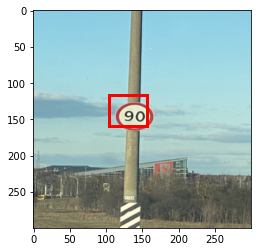

In [33]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])